In [1]:
import pandas as pd
import pickle
import torch
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
import matplotlib.transforms as mtrans
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils import data
from modules import *
from base import BaseObjective
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# # Load the pre-trained BERT model and tokenizer 
# tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
# model = AutoModel.from_pretrained('bert-base-uncased')

# # Create a sample dataframe with messages and their labels
# df = pd.read_csv('data/spam.csv', encoding='ISO-8859-1', usecols=[0, 1]).rename(columns={'v2': 'message', 'v1': 'label'})

# # Define a function to generate embeddings for a given message
# def generate_embedding(message):
#     # Tokenize the message and convert to tensors
#     input_ids = torch.tensor([tokenizer.encode(message, add_special_tokens=True)])
#     # Generate the BERT embeddings
#     with torch.no_grad():
#         outputs = model(input_ids)
#         last_hidden_states = outputs.last_hidden_state[0]
#     # Return the mean of the embedding vectors
#     return torch.mean(last_hidden_states, dim=0)

# # Apply the generate_embedding function to all messages in the dataframe
# # tqdm.pandas(desc="Processing rows")
# # df['embedding'] = df['message'].progress_apply(generate_embedding)

# # Print the updated dataframe
# # print(df)



2023-10-17 12:58:04.102302: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 12:58:05.042012: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
with open('data/spambert.pkl', 'rb') as f:
    df = pickle.load(f)

# Load the pre-trained BERT model and tokenizer
# tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
# model = AutoModel.from_pretrained('bert-base-uncased')

# data1 = {
#     'message': [
# 'Désolé, je vais appeler plus tard',
# 'Bravo! À vous le pass spécial cinéma 1 an pour 2. appelez le 09061209465 maintenant !',
# "Vous avez gagné un Nokia 7250i. C'est ce que vous obtenez lorsque vous remportez notre enchère GRATUITE. Pour participer, envoyez Nokia au 86021 maintenant. HG/Suite342/2Lands Row/W1JHL 16+",
# "Wow... je t'aime tellement, tu sais ? Je peux à peine le supporter ! Je me demande comment se passe ta journée et si tu vas bien, mon amour... Je pense à toi et tu me manques",
# "Faites-moi savoir comment cela change dans les 6 prochaines heures. Il peut même s'agir d'une appendice mais vous êtes en dehors de cette tranche d'âge. Cependant ce n'est pas impossible. Alors détends-toi et fais-moi savoir dans 6 heures",
# "Carlos a mis du temps (encore), on part dans une minute",
# "Gros courage a cette enfant en espérant que sa vu s'améliore avec le temps et n'écoute pas les moquerie",
# "au moins il pourra pas voir la tristesse de ce monde... ( sans mauvais jeu de mot...) Je lui souhaite que du bonheur ;",
# "Lorsque j'étais à l'école , j'avais aussi un handicap. J'étais autisme. Le jour où je comprends très bien que j'ai un problème, j'ai essayé d'être normal comme les autres. Maintenant, ça va mieux. ",
# "Mon dieux sa doit être difficile quand il va entrer au collège et lycée les autres vont se moquer de lui, j'espère qui va allez mieux",
# "J'adore comment tout le monde parle des cheveux rose du profs mais pas vraiment du chien qui s'appelle Obi-fookin-Wan",
# "Si Théo est malvoyant pourquoi ils ne le mettent pas au premier rang au lieu de le laisser au dernier rang ça pourra lui apporter une aide en plus de son ordinateur pour zoomer",
# "petit suggestion : peut être que ça serait plus judicieux de le mettre au premier rang plutôt qu'au dernier s'il est malvoyant",
# "Je le demande quesqui est le plus bizarre, un jeune homme qui vas à l'école avec son chien d'aveugle, ou le prof avec des cheveux",
# "Moi aussi je suis malvoyant et Les conditions sont similaires pour moi les exercice et certains cours me sont fournies par le biais de l'outil informatique j'ai également une caméra vidéo agrandisseur pour voir au tableau l'avantage c'est que je peux travailler comme tout le monde",
# "Très beau chien",
# "C est genial bravo a cet etablissement",
# "Les gens qui disent qu’il faut qu’ils le mette au premier rang, vous êtes bêtes ou vous le faites exprès ?",
# "je vois pas de l’œil gauche mais dieux merci mon œil droit va bien heureusement qu’il est accepté comme il est",
# "On m'explique pourquoi le gars on le met pas au premier rang devant le tableau si il voit mal",
# "c'est un enfant comme tout le monde mais il est seul au recreation en effet il est vachement comme tous le monde au yeux des gens franchement arreter votre hypocrisie 2min",
# "On en parle il est mal voyant et il l’on mit a l’arrière de la classe",
# "Par contre vous ferez attention c’est « professeur de mathématiques » mathématique avec un s",
# "Chuis la seule a être choquer par la couleur des cheveux du prof mdrr",
# "Moi  aussi je vois pas de l'oeil gauche mais mon oeil gauche est parfait",
# "À quelle moment un prof a une teinture roze",
# "Ah, je comprends pas pourquoi tout le monde parle de la couleur des cheveux du prof?",
# "Félicitations, vous avez gagné un iPhone X ! Cliquez ici pour réclamer votre prix !",
# "Obtenez un prêt rapide et facile, même avec un mauvais crédit. Appelez dès maintenant !",
# "Gagnez de l'argent rapidement en travaillant depuis chez vous ! Aucune expérience requise !",
# "Votre compte bancaire a été suspendu. Cliquez ici pour le réactiver immédiatement.",
# "Réduisez vos dettes en un rien de temps ! Contactez-nous pour une consultation gratuite.",
# "Vous avez été sélectionné pour une offre spéciale : un voyage de rêve à prix réduit !",
# "Gros lot de loterie international ! Vous êtes le gagnant, réclamez votre prix maintenant !",
# "Votre ordinateur est infecté par un virus. Téléchargez notre logiciel de protection dès maintenant !",
# "Gagnez de l'argent en ligne en regardant des publicités. Inscrivez-vous dès maintenant !",
# "Vous avez été choisi pour une enquête exclusive. Répondez et recevez une carte-cadeau gratuite !",
# "Bonjour, comment ça va aujourd'hui ?",
# "Le soleil brille, c'est une belle journée !",
# "J'ai hâte de te revoir bientôt !",
# "As-tu des projets passionnants pour le week-end ?",
# "La vie est belle, profitons-en au maximum !",
# "Un café, s'il vous plaît, bien serré.",
# "La musique adoucit les mœurs, n'est-ce pas ?",
# "Quel est ton plat préféré ?",
# "Rien de mieux qu'une soirée cinéma à la maison.",
# "Joyeux anniversaire ! Que cette journée soit spéciale.",
# "Je rêve de voyager à travers le monde un jour.",
# "Savais-tu que les étoiles scintillent la nuit ?",
# "Faisons une pause et dégustons du fromage et du vin.",
# "La nature offre une beauté infinie à explorer.",
# "Le rire est le meilleur remède contre le stress.",
# "Les amis sont comme des étoiles, on ne les voit pas toujours, mais on sait qu'ils sont là.",
# "La lecture est une porte ouverte vers un monde imaginaire.",
# "Le chocolat, c'est la réponse, peu importe la question !",
# "Chaque jour est une nouvelle aventure qui commence.",
# "Apprécions les petites choses de la vie, elles font toute la différence.",
# "Quelqu'un a contacté notre service de rencontres et a saisi votre téléphone parce que vous lui plaisez ! Pour savoir de qui il s'agit, appelez depuis un téléphone fixe le 09058098002",
# "Mon amie, elle étudie à Warwick, nous avons prévu d'aller faire du shopping et d'aller à un concert, mais ça pourrait être annulé, je ne l'ai pas vu depuis des lustres, ouais, nous devrions nous voir un jour !",
# "Vous avez été spécialement sélectionné pour recevoir une récompense de 2000 livres ! Appelez le 08712402050 AVANT la fermeture des lignes. Coût 10 ppm. 16+. Les conditions générales s'appliquent. AG Promo",
# "Belle vérité contre la gravité.. Lisez attentivement : Votre cœur est léger quand quelqu'un est dedans.. Mais il est très lourd quand quelqu'un le quitte. BONJOUR",
# "Votre compte PayPal a été suspendu. Connectez-vous immédiatement pour le réactiver."
# "Devenez millionnaire en 30 jours grâce à notre programme secret !",
# "Gagnez de l'argent en dormant ! Découvrez notre méthode révolutionnaire !",
# "Vous avez un message vocal non écouté. Cliquez ici pour l'écouter maintenant.",
# "Réclamez votre réduction exclusive de 90 % sur tous les produits de santé !",
# "Votre facture est en retard ! Cliquez ici pour régler la dette immédiatement.",
# "Gagnez un voyage de luxe tout inclus pour deux personnes. Validez votre victoire ici !",
# "Votre prêt personnel a été approuvé. Obtenez de l'argent rapidement !",
# "Vous avez gagné un bon d'achat de 500 €. Réclamez-le maintenant en cliquant ici !",
# "Recevez des médicaments bon marché sans ordonnance. Commandez dès aujourd'hui !",
# "Obtenez une promotion spéciale sur des pilules pour maigrir. Perdez du poids rapidement !",
# "Investissez dans cette opportunité en or ! Devenez riche en quelques semaines !",
# "Vous avez gagné 1 million d'euros dans notre loterie internationale. Réclamez votre prix !",
# "Votre compte en banque est en danger. Cliquez ici pour sécuriser vos informations.",
# "Réductions exceptionnelles sur des montres de luxe. Ne ratez pas cette offre unique !",
# "Gagnez de l'argent en ligne en suivant notre programme miracle. Inscription gratuite !",
# "Vous avez été sélectionné pour une enquête rémunérée. Cliquez pour commencer !",
# "Votre prêt personnel est prêt à être approuvé. Aucune vérification de crédit requise !",
# "Gagnez un voyage de rêve pour deux dans les Caraïbes. Réservez maintenant !",
# "Recevez des échantillons gratuits de produits de beauté. Inscrivez-vous dès maintenant !",
# "Cher client, votre facture d'électricité pour le mois de septembre s'élève à 75 €.",
# "Votre réservation de vol a été confirmée. Voici les détails de votre itinéraire.",
# "Joyeux anniversaire ! Nous vous offrons une réduction spéciale de 10 % sur votre prochain achat.",
# "La réunion de l'équipe est prévue demain à 10 h. Merci de confirmer votre présence.",
# "Bonjour, c'est votre médecin. Votre rendez-vous de suivi est fixé au 20 septembre.",
# "Votre colis a été expédié et sera livré demain. Suivez la livraison ici : [lien de suivi].",
# "Votre abonnement au service de streaming a été renouvelé avec succès. Profitez de notre contenu.",
# "Chers parents, l'école organise une réunion des parents d'élèves le 25 septembre à 18 h.",
# "Merci de votre commande chez [Nom du restaurant]. Votre repas sera livré dans 30 minutes.",
# "Vos points de fidélité ont été mis à jour. Vous avez maintenant 500 points à utiliser.",
# "Gagnez de l'argent rapidement en travaillant de chez vous !",
# "Vous avez gagné un iPhone X. Cliquez ici pour le réclamer !",
# "Obtenez un prêt instantané sans vérification de crédit.",
# "Votre compte bancaire a été suspendu. Réactivez-le maintenant.",
# "Réductions incroyables sur les médicaments en ligne. Commandez dès aujourd'hui !",
# "Devenez millionnaire en investissant dans notre entreprise.",
# "Gagnez un voyage de luxe tout inclus pour deux. Réservez maintenant !",
# "Votre prêt personnel est approuvé. Obtenez de l'argent rapidement !",
# "Recevez un bon d'achat de 500 €. Réclamez-le en cliquant ici !",
# "Ne ratez pas cette offre spéciale pour des produits de beauté gratuits !",
# "Cher(e) client(e), votre relevé de compte pour août est maintenant disponible en ligne.",
# "Votre vol a été confirmé pour le 15 septembre. Voici votre numéro de réservation : XXX123.",
# "Merci d'avoir choisi notre service de streaming. Découvrez nos dernières séries et films !",
# "La réunion du conseil d'administration est prévue le 22 septembre à 14 h. Agenda inclus.",
# "Votre abonnement à la newsletter a été mis à jour. Restez informé de nos dernières actualités.",
# "Votre commande chez [Nom du restaurant] est en route. Vous la recevrez sous peu.",
# "Chers parents, l'école organise une vente de gâteaux le 30 septembre pour collecter des fonds.",
# "Joyeux anniversaire ! Vous bénéficiez d'une remise de 20 % sur tous les produits aujourd'hui.",
# "Votre colis est prêt à être expédié. Suivez la livraison avec ce lien de suivi : [lien].",
# "Félicitations ! Vous avez accumulé suffisamment de points de récompense pour une réduction de 10 €."],
    
#     'label': ["ham" if i%4==1 else "spam" for i in range(110)]
# }

# new_row = pd.DataFrame(data1)


# # Define a function to generate embeddings for a given message
# def generate_embedding(message):
#     # Tokenize the message and convert to tensors
#     input_ids = torch.tensor([tokenizer.encode(message, add_special_tokens=True)])
#     # Generate the BERT embeddings
#     with torch.no_grad():
#         outputs = model(input_ids)
#         last_hidden_states = outputs.last_hidden_state[0]
#     # Return the mean of the embedding vectors
#     return torch.mean(last_hidden_states, dim=0)

# # Apply the generate_embedding function to all messages in the dataframe
# tqdm.pandas(desc="Processing rows")
# new_row['embedding'] = new_row['message'].progress_apply(generate_embedding)
    
# df = pd.concat([new_row,df.loc[:]]).reset_index(drop=True)
df['label'] = df['label'].replace({'spam': 1, 'ham': 0})

In [3]:
X=torch.stack(df.embedding.tolist())
y=df.label

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=30)
# 54- birthdate

In [4]:
text_train = df.message[Y_train.index].tolist()
X_train = torch.tensor(X_train)
Y_train = torch.tensor(Y_train.tolist()).type('torch.FloatTensor')

text_test = df.message[Y_test.index].tolist()
Y_test = torch.tensor(Y_test.tolist()).type('torch.FloatTensor')
X_test = torch.tensor(X_test)

/tmp/ipykernel_88020/4293265550.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train)
/tmp/ipykernel_88020/4293265550.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test)


In [ ]:
Y_train[1]

In [ ]:
for i in range(len(Y_train)):
    if text_train[i] not in data1["message"]:
        

In [ ]:
# rule2
# for i, j in enumerate(text_train):
#     if '?' in j and len(j)<30:
#         if i%4==1:
#             Y_train[i]=torch.tensor(1.0)
#         else:
#             Y_train[i]=torch.tensor(0.0)
            
# for i, j in enumerate(text_test):
#     if '?' in j and len(j)<30:
#         if i%4==1:
#             Y_test[i]=torch.tensor(1.0)
#         else:
#             Y_test[i]=torch.tensor(0.0)
        
rule2test = [i for i, j in enumerate(text_train)
         if '?' in j and len(j)<30]

In [14]:
# Rule 3
import re
pattern = r'\d{4,}'

for i, j in enumerate(text_test):
    if re.search(pattern, j):
        if i%4==1:
            Y_test[i]=torch.tensor(1.0)
        else:
            Y_test[i]=torch.tensor(0.0)
            
for i, j in enumerate(text_train):
    if re.search(pattern, j):
        if i%4==1:
            Y_train[i]=torch.tensor(1.0)
        else:
            Y_train[i]=torch.tensor(0.0)

In [16]:
rule33=[i for i, j in enumerate(text_train) if re.search(pattern, j) and Y_train[i]==torch.tensor(0)]
len(rule33)

378

In [5]:
L2_WEIGHT = 1e-4
def fit_model(X, Y):
    C = 1 / (X.shape[0] * L2_WEIGHT)
    sk_clf = linear_model.LogisticRegression(C=C, tol=1e-8, max_iter=1000)
    sk_clf = sk_clf.fit(X.numpy(), Y.numpy())

    # recreate model in PyTorch
    fc = nn.Linear(768, 1, bias=True)
    fc.weight = nn.Parameter(torch.tensor(sk_clf.coef_))
    fc.bias = nn.Parameter(torch.tensor(sk_clf.intercept_))

    pt_clf = nn.Sequential(
        fc,
        nn.Flatten(start_dim=-2),
        nn.Sigmoid()
    )

    pt_clf = pt_clf.to(device=DEVICE, dtype=torch.float32)
    return pt_clf

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_set = data.TensorDataset(X_train, Y_train)
test_set = data.TensorDataset(X_test, Y_test)
clf = fit_model(X_train, Y_train)

In [14]:
import math
loglik = [math.log(clf(X_train[i].unsqueeze(0)).item()) for i in range(len(Y_train)) if i not in rule33]
sum(loglik)/len(loglik)

-9.446624600837952

In [ ]:
spam_fr=[clf(X_test[i].unsqueeze(0)).item() for i in range(len(Y_test)) if text_test[i] in data1['message']]+[clf(X_train[i].unsqueeze(0)).item() for i in range(len(Y_train)) if text_train[i] in data1['message']]
sum(spam_fr)/len(spam_fr)

In [ ]:
ham_fr=[clf(X_test[i].unsqueeze(0)).item() for i in range(len(Y_test)) if Y_test[i]==torch.tensor(0.0) and text_test[i] in data1['message']]
sum(ham_fr)/len(ham_fr)

In [ ]:
spam_fr

In [ ]:
before=[clf(X_test[i].unsqueeze(0)).item() for i, j in enumerate(text_test)
         if '?' in j and len(j)<30]

In [ ]:
after=[clf(X_test[i].unsqueeze(0)).item() for i, j in enumerate(text_test)
         if '?' in j and len(j)<30]

In [ ]:
len([i for i in range(len(after)) if before[i]>after[i]])

In [ ]:
before

In [ ]:
122/len(after)

In [ ]:
# Rule 1
# inx_rule = [i for i, j in enumerate(text_test) if j in data1['message']]
# inxt_rule = [i for i, j in enumerate(text_train) if j in data1['message']]
# [f'GT:{Y_train[i]} Prd: {clf(X_train[i].unsqueeze(0))}' for i in inxt_rule]
# [f'GT:{Y_test[i]} Prd: {clf(X_test[i].unsqueeze(0))}' for i in inx_rule]

In [ ]:
[f'GT:{Y_test[i]} Prd: {clf(X_test[i].unsqueeze(0))}' for i, j in enumerate(text_test)
         if re.search(pattern, j)]

In [ ]:
Y_test[728]

In [ ]:
#Aphorism rule
# Y_train[1241]=torch.tensor(0.)
# Y_train[2326]=torch.tensor(0.)
# Y_train[1910]=torch.tensor(0.)
# Y_train[985]=torch.tensor(0.)

# Y_test[151]=torch.tensor(0.)

In [ ]:
clf(X_test[728].unsqueeze(0)).item()

In [6]:
class BinClassObjective(BaseObjective):

    def train_outputs(self, model, batch):
        return model(batch[0])

    def train_loss_on_outputs(self, outputs, batch):
        return F.binary_cross_entropy(outputs, batch[1])

    def train_regularization(self, params):
        return L2_WEIGHT * torch.square(params.norm())

    def test_loss(self, model, params, batch):
        outputs = model(batch[0])
        return F.binary_cross_entropy(outputs, batch[1])
    
module = LiSSAInfluenceModule(
    model=clf,
    objective=BinClassObjective(),
    train_loader=data.DataLoader(train_set, batch_size=32),
    test_loader=data.DataLoader(test_set, batch_size=32),
    device=DEVICE,
    damp=0.001,
    repeat= 1,
    depth=1800,
    scale= 10,
)

In [7]:
import torch.nn.functional as F
def df_construct(test_idx, train_idxs):
    influences = module.influences(train_idxs=train_idxs, test_idxs=[test_idx])
    similarity=[cosine_similarity(X_test[test_idx].numpy().reshape(1,-1), X_train[i].numpy().reshape(1, -1)).item()
               for i in range(len(X_train))]
#     squared_diff = (clf(X_train.to(DEVICE)) - y_train.to(DEVICE))**2

#     # Calculate the RMS error for each training point
#     train_losses = torch.sqrt(squared_diff)

#     # Detach the tensor from the computation graph
#     train_losses = train_losses.detach().requires_grad_(False)
#     relatif=influences/train_losses
    data = {'Influence': influences.reshape(-1).tolist(), 'Similarity': similarity, 'Label':Y_train.tolist(), 
            'X_train':X_train.numpy().tolist(), 'message':text_train}
    df = pd.DataFrame(data)
    return df
# test_idx = 728      
train_idxs = list(range(X_train.shape[0]))
# df = df_construct(test_idx, train_idxs)

In [8]:
def input_data(df, test_idx, sett=None):
    
    scaler = MinMaxScaler()
    
    influence_pos = [i for i in df.Influence.tolist() if i>0]
    q3p, q1p = np.percentile(influence_pos, [75 ,25])
    iqrp = q3p - q1p
    influenceIQp=np.array([i for i in influence_pos if i>q3p+3*iqrp])
    n_p=len(influenceIQp)
    
    influence_neg = [i for i in df.Influence.tolist() if i<0]
    q3n, q1n = np.percentile(influence_neg, [75 ,25])
    iqrn = q3n - q1n
    influenceIQn=np.array([i for i in influence_neg if i<q1n-2*iqrn])
    nn=len(influenceIQn)
    
    if sett == 'positive':

        df_pos = df[df.Influence>0].sort_values('Influence', ascending=False) #.reset_index(drop=True)
        df_pos[['Influence', 'Similarity']]= scaler.fit_transform(df_pos[['Influence', 'Similarity']])
        df_pos_sl = df_pos[df_pos.Label==Y_test[test_idx].item()][:n_p]
        df_pos_ol = df_pos[df_pos.Label!=Y_test[test_idx].item()][:n_p]
        
        return df_pos_sl, df_pos_ol
    
    elif sett=='negative':
       
        df_neg = df[df.Influence<0].sort_values('Influence', ascending=True) #.reset_index(drop=True)
        df_neg[['Influence', 'Similarity']]= scaler.fit_transform(df_neg[['Influence', 'Similarity']])
        df_neg_sl = df_neg[df_neg.Label==Y_test[test_idx].item()][:nn]
        df_neg_ol = df_neg[df_neg.Label!=Y_test[test_idx].item()][:nn]
        
        return df_neg_ol, df_neg_sl

In [10]:
def calculate_cosine_similarity(a, b):
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    similarity = dot_product / (norm_a * norm_b)
    return similarity

def greedy_subset_selection(df, N, sett=None, label=None):
    
    arrays = [np.array(i) for i in df.X_train]
    influence_scores = df.Influence.tolist()  # List of influence scores for each array
    prox = df.Similarity.tolist()
    n_arrays = len(arrays)
    selected_indices = []
    
    wi, ws, wd=0.2, 0.9, 0.3
 
    # Start with the array with the highest influence score
    if sett =='positive' and label=='opposite':
        initial_idx = np.argmax(influence_scores)
    elif sett =='positive' and label=='same':
        initial_idx = np.argmax(influence_scores)
    if sett =='negative' and label=='opposite':
        initial_idx = np.argmax(influence_scores)
    elif sett =='negative' and label=='same':
        initial_idx = np.argmax(influence_scores)
    selected_indices.append(initial_idx)
    selected_array = arrays[initial_idx]
    
    while len(selected_indices) < N:
        max_gain = -np.inf
        selected_idx = None
        
        # Iterate over the remaining arrays
        for i in range(n_arrays):
            if i not in selected_indices:
                current_array = arrays[i]
                final_list = list(map(lambda x: calculate_cosine_similarity(current_array, arrays[x]), selected_indices))
                if any(i>0.97 for i in final_list):
                    continue
                else:
                    
                    diversity = np.mean(final_list)
                    # Calculate combined score of diversity and influence score
                    if sett =='positive' and label=='same':
                        combined_score = 0.4*influence_scores[i]+0.8*prox[i] #-0.3*diversity
#                         combined_score = wi*influence_scores[i] + ws*prox[i] - wd*similarity
                    elif sett =='negative' and label=='opposite':
                        combined_score = -0.4*influence_scores[i]+0.8*prox[i] #- 0.3*diversity                        
                    elif sett =='positive' and label=='opposite':
                        combined_score = 0.4*influence_scores[i]+0.8*prox[i] #-0.3*diversity
#                         combined_score = wi*influence_scores[i] - wd*similarity
                    elif sett =='negative' and label=='same':
                        combined_score = -0.4*influence_scores[i]+0.8*prox[i] #-0.3*diversity
                    # Update selected array if it provides the highest gain
                    if combined_score > max_gain:
                        max_gain = combined_score
                        selected_idx = i
        
        # Add selected array to the subset
        selected_indices.append(selected_idx)
    
    return selected_indices


# df_pos_sl, df_pos_ol = input_data(df, test_idx, sett='positive')
# df_neg_ol, df_neg_sl = input_data(df, test_idx, sett='negative')
# selected_indices_pos_sl = greedy_subset_selection(df_pos_sl, N=10, sett='positive', label='same')
# selected_indices_pos_ol = greedy_subset_selection(df_pos_ol, N=10, sett='positive', label='opposite')
# selected_indices_neg_sl = greedy_subset_selection(df_neg_sl, N=10, sett='negative', label='same')
# selected_indices_neg_ol = greedy_subset_selection(df_neg_ol, N=10, sett='negative', label='opposite')

In [ ]:
def expl_rule(test_idx):
    df=df_construct(test_idx, train_idxs)
    df_pos_sl, df_pos_ol = input_data(df, test_idx, sett='positive')
    df_neg_ol, df_neg_sl = input_data(df, test_idx, sett='negative')
    selected_indices_pos_sl = greedy_subset_selection(df_pos_sl, N=10, sett='positive', label='same')
    selected_indices_neg_ol = greedy_subset_selection(df_neg_ol, N=10, sett='negative', label='opposite')
    sup=[df_pos_sl.message.tolist()[i] for i in selected_indices_pos_sl]
    op=[df_neg_ol.message.tolist()[i] for i in selected_indices_neg_ol]
    return sup, op

In [ ]:
# Rule 1 precision
precision_sup=[]
precision_op=[]
for i in inx_rule:
    sup, op=expl_rule(i)
    precision_sup.append(len([i for i,j in enumerate(sup) if j in data1['message']])/len(sup))
    precision_op.append(len([i for i,j in enumerate(op) if j in data1['message']])/len(op))

print(f' Precision of supporters: {sum(precision_sup)/len(precision_sup)},{/n} Precision of opposers: {sum(precision_op)/len(precision_op)}')


In [ ]:
# Rule 2 precision
precision_sup=[]
precision_op=[]
for i in tqdm(rule3test):
    print(i)
    sup, op=expl_rule(i)
    precision_sup.append(len([i for i,j in enumerate(sup) if '?' in j and len(j)<30])/len(sup))
    precision_op.append(len([i for i,j in enumerate(op) if '?' in j and len(j)<30])/len(op))

print(f' Precision of supporters: {sum(precision_sup)/len(precision_sup)}, Precision of opposers: {sum(precision_op)/len(precision_op)}')


In [ ]:
# Rule 3 precision
precision_sup=[]
precision_op=[]
for i in tqdm(rule33):
    print(i)
    sup, op=expl_rule(i)
    precision_sup.append(len([i for i,j in enumerate(sup) if re.search(pattern, j)])/len(sup))
    precision_op.append(len([i for i,j in enumerate(op) if re.search(pattern, j)])/len(op))

print(f' Precision of supporters: {sum(precision_sup)/len(precision_sup)}, Precision of opposers: {sum(precision_op)/len(precision_op)}')


In [ ]:
[i for i,j in enumerate(op) if '?' in j and len(j)<30]

In [ ]:
df_pos_sl.index[4]

In [ ]:
a=[(df_pos_sl.message.tolist()[i], clf(X_train[df_pos_sl.index[i]].unsqueeze(0)).item(), df_pos_sl.Label.tolist()[i]) for i in selected_indices_pos_sl]
a

In [ ]:
a1=[i[1] for i in a if i[0] in data1['message']]
sum(a1)/len(a1)

In [ ]:
b=[(df_pos_ol.message.tolist()[i], clf(X_train[df_pos_ol.index[i]].unsqueeze(0)).item(), df_pos_ol.Label.tolist()[i]) for i in selected_indices_pos_ol]
b

In [ ]:
b1=[i[1] for i in b if i[0] in data1['message']]
sum(b1)/len(b1)

In [ ]:
c=[(df_neg_sl.message.tolist()[i], clf(X_train[df_neg_sl.index[i]].unsqueeze(0)).item(), df_neg_sl.Label.tolist()[i]) for i in selected_indices_neg_sl]
c

In [ ]:
c1=[i[1] for i in c if i[0] in data1['message']]
sum(c1)/len(c1)

In [ ]:
d=[(df_neg_ol.message.tolist()[i], clf(X_train[df_neg_ol.index[i]].unsqueeze(0)).item(), df_neg_ol.Label.tolist()[i]) for i in selected_indices_neg_ol]
d

In [ ]:
d1=[i[1] for i in d if i[0] in data1['message']]
sum(d1)/len(d1)

100%|█████████████████████████████████████████████████████████████████| 1/1 [00:25<00:00, 25.28s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


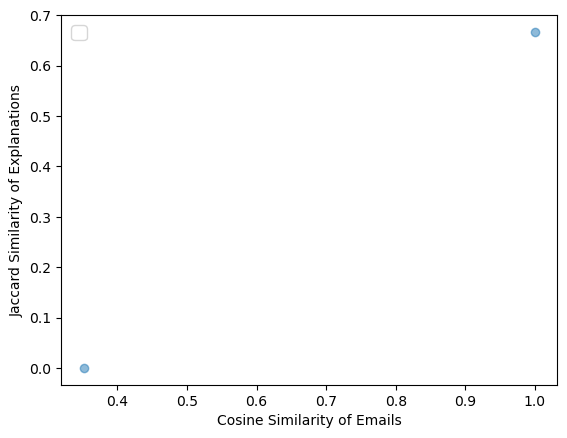

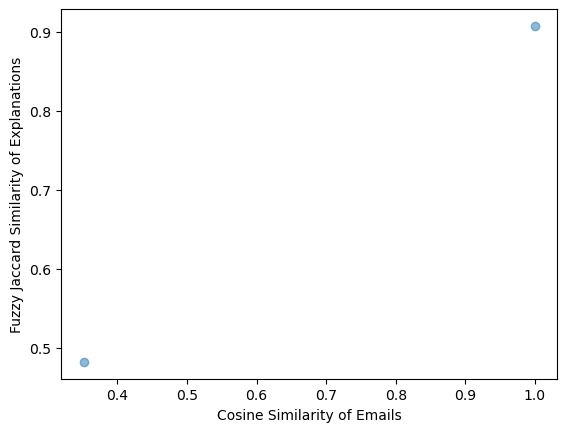

In [18]:
from scipy.optimize import linear_sum_assignment


def find_best_matches(embeddings_list1, embeddings_list2):
    # Compute cosine similarity matrix
    similarity_matrix = cosine_similarity(embeddings_list1, embeddings_list2)

    # Use the Hungarian algorithm to find the optimal assignment
    row_indices, col_indices = linear_sum_assignment(-similarity_matrix)

    # Extract the pairs of best matches and their corresponding similarity scores
    best_matches = [(row_indices[i], col_indices[i]) for i in range(len(row_indices))]
    similarity_scores = [-similarity_matrix[row][col] for row, col in best_matches]

    return best_matches, similarity_scores

def average_mbm_similarity(embeddings_list1, embeddings_list2):
    # Find the best matches and their similarity scores
    best_matches, similarity_scores = find_best_matches(embeddings_list1, embeddings_list2)

    # Compute the average cosine similarity using the similarity scores
    avg_similarity = np.mean(np.abs(similarity_scores))
    
    return avg_similarity

def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union

def get_explanation(i):
    
        df = df_construct(i, train_idxs)
        df_pos_sl, df_pos_ol = input_data(df, i, sett='positive')
        df_neg_ol, df_neg_sl = input_data(df, i, sett='negative')
        selected_indices_pos_sl = greedy_subset_selection(df_pos_sl, N=5, sett='positive', label='same')
        selected_indices_pos_ol = greedy_subset_selection(df_pos_ol, N=5, sett='positive', label='opposite')
        selected_indices_neg_sl = greedy_subset_selection(df_neg_sl, N=5, sett='negative', label='same')
        selected_indices_neg_ol = greedy_subset_selection(df_neg_ol, N=5, sett='negative', label='opposite')
        a=[df_pos_sl.Influence.index[k] for k in selected_indices_pos_sl]
        b=[df_neg_ol.Influence.index[k] for k in selected_indices_neg_ol]
        c=[df_neg_sl.Influence.index[k] for k in selected_indices_neg_sl]
        d=[df_pos_ol.Influence.index[k] for k in selected_indices_pos_ol]
        return a+b

def aide_eval(test_idx):
    simlist=np.array([cosine_similarity(X_test[test_idx].numpy().reshape(1,-1), X_test[i].numpy().reshape(1, -1)).item() for i in range(len(X_test))])
    mostsim=simlist.argsort()[-1:]
    leastsim=simlist.argsort()[:1]
    concatenated_array = np.concatenate((mostsim, leastsim)).tolist()
    cosine_sim=simlist[[concatenated_array]]
    set1=get_explanation(test_idx)
#     mean_ex_similarity=[]
    jaccard_sim=[]
    mbm_sim=[]
    fuzzy_jac=[]
    for i in tqdm(concatenated_array):
        set2=get_explanation(i)
        jaccard_sim.append(jaccard_similarity(set(set1), set(set2)))
#         similarity_matrix = cosine_similarity(X_train[[set1]], X_train[[set2]])
#         mean_ex_similarity.append(np.mean(similarity_matrix))
        mbm=average_mbm_similarity(X_train[[set1]], X_train[[set2]])
#         mbm_sim.append(mbm)
        fuzzy_jac.append(mbm/(len(set2)/5 - mbm))
    return cosine_sim.flatten().tolist(), mbm_sim, fuzzy_jac,jaccard_sim

import random
sample_idx = random.sample(range(0, X_test.shape[0]), 1)
cosine_total=[]
# mbm_total=[]
fuzzy_total=[]
jaccard_total=[]
for i in tqdm(sample_idx):
    cosine_sim, mbm_sim, fuzzy_jac,jaccard_sim = aide_eval(i)
    cosine_total.append(cosine_sim)
#     mbm_total.append(mbm_sim)
    fuzzy_total.append(fuzzy_jac)
#     mean_total.append(mean_ex_similarity)
    jaccard_total.append(jaccard_sim)

plt.figure()
plt.scatter(cosine_total, jaccard_total, alpha=0.5)
plt.xlabel('Cosine Similarity of Emails')
plt.ylabel('Jaccard Similarity of Explanations')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.legend(fontsize=14)

plt.figure()
plt.scatter(cosine_total, fuzzy_total, alpha=0.5)
plt.xlabel('Cosine Similarity of Emails')
plt.ylabel('Fuzzy Jaccard Similarity of Explanations')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42


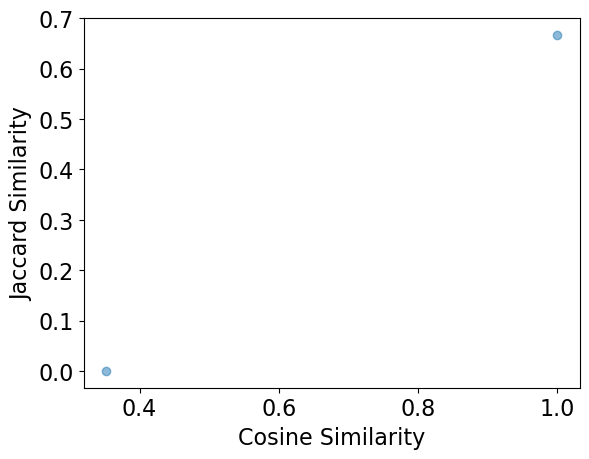

In [40]:
plt.rcParams.update({'font.size': 16})
plt.figure()
plt.scatter(cosine_total, jaccard_total, alpha=0.5)
plt.xlabel('Cosine Similarity')
plt.ylabel('Jaccard Similarity')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# plt.savefig('your_plot.pdf', bbox_inches='tight')

In [37]:
fuzzy_jac

[0.9075886017562392, 0.4822660027581084]

In [ ]:
# Initialize the t-SNE algorithm
tsne = TSNE(n_components=2, random_state=42)

# Combine the training and test tensors
X = torch.cat((X_train, X_test), dim=0)
y = torch.cat((y_train, y_test), dim=0)

# Convert the tensors to numpy arrays
X = X.numpy()
y = y.numpy()

# Initialize the t-SNE algorithm
tsne = TSNE(n_components=2, random_state=42)

# Fit and transform the data to 2D
X_2d = tsne.fit_transform(X)

# Plot the data in 2D with different colors and alpha values for each class
plt.scatter(X_2d[y==0, 0], X_2d[y==0, 1], marker='o', c='#7FFFD4',  label='Ham', alpha=0.7)
plt.scatter(X_2d[y==1, 0], X_2d[y==1, 1], marker='o', c='#FFE5B4',  label='Spam', alpha=0.5)



plt.scatter(X_2d[len(y_train)+test_idx][0], X_2d[len(y_train)+test_idx][1], marker='.', color='red')

plt.scatter([X_2d[df_pos_sl.index[i]][0] for i in selected_indices_pos_sl],
        [X_2d[df_pos_sl.index[i]][1] for i in selected_indices_pos_sl], marker='+', color='black', label='Support by Relevance')

# plt.scatter([X_2d[df_pos_ol.index[i]][0] for i in selected_indices_pos_ol],
#         [X_2d[df_pos_ol.index[i]][1] for i in selected_indices_pos_ol], marker='x', color='orange', label='Support by Contrast')

# plt.scatter([X_2d[df_neg_sl.index[i]][0] for i in selected_indices_neg_sl],
#         [X_2d[df_neg_sl.index[i]][1] for i in selected_indices_neg_sl], marker='+', color='black', label='Oppose by Contrast')

plt.scatter([X_2d[df_neg_ol.index[i]][0] for i in selected_indices_neg_ol],
        [X_2d[df_neg_ol.index[i]][1] for i in selected_indices_neg_ol], marker='x', color='blue', label='Oppose by Relevance')

# plt.scatter([X_2d[df_pos_sl.index[i]][0] for i in range(3)], [X_2d[df_pos_sl.index[i]][1] for i in range(3)],
#             marker='*', color='red', label='Influential Instances')
# plt.scatter([X_2d[df_pos_sl.sort_values('Similarity', ascending=False).index[i]][0] for i in range(3)],
#             [X_2d[df_pos_sl.sort_values('Similarity', ascending=False).index[i]][1] for i in range(3)],
#             marker='+', color='green', label='Similar Instances')

plt.legend()
plt.savefig(f'tsne_aide{test_idx}.pdf', format='pdf')
plt.show()